In [2]:
# Step 1: Install dependencies
!pip install -q datasets albumentations opencv-python pytorch-lightning torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.2 MB/s eta 0:00:00


In [3]:
# Step 2: Load HF dataset, parse OCR boxes into polygons, and split into train/val

from datasets import load_dataset
import json

# Load raw "train" split from HF
raw_dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1", split="train")

def prepare_dbnet(example):
    raw = json.loads(example["raw_data"])
    boxes = eval(raw["ocr_boxes"])   # list of (box, (text, conf))

    polygons = []
    for box, (text, conf) in boxes:
        flat = []
        for point in box:
            flat += [point[0], point[1]]
        polygons.append({"text": text, "poly": flat})

    example["polygons"] = polygons
    return example

# Apply preprocessing (adds "polygons" field)
dataset = raw_dataset.map(prepare_dbnet)

# Create train/val split (e.g., 80% train, 20% val)
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_hf = splits["train"]
val_hf   = splits["test"]

print("Train size:", len(train_hf))
print("Val size:", len(val_hf))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/782 [00:00<?, ?B/s]

data/train-00000-of-00001-76ffc8319f74dd(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/test-00000-of-00001-af2d92d1cee2851(…):   0%|          | 0.00/18.8M [00:00<?, ?B/s]

data/valid-00000-of-00001-894b4e1f736b57(…):   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/125 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/2043 [00:00<?, ? examples/s]

Train size: 1634
Val size: 409


In [4]:
# Step 3: Define DBNet model with ResNet18 backbone

import torch
import torch.nn as nn
import torchvision.models as models

class DBNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Keep only convolutional layers
        self.backbone = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4
        )
        self.conv = nn.Conv2d(512, 64, kernel_size=1)    # 512 for ResNet18
        self.binarize = nn.Conv2d(64, 1, 3, padding=1)   # raw logits

    def forward(self, x):
        f = self.backbone(x)  # [B, 512, H/32, W/32]
        f = self.conv(f)
        prob_map = self.binarize(f)  # [B, 1, H/32, W/32]
        return prob_map


In [5]:
import torch.nn as nn

# Loss function for DBNet
db_loss = nn.BCEWithLogitsLoss()


In [6]:
# Step 5: Image transform and mask creation from polygons

from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np

# Image transform
base_transform = transforms.Compose([
    transforms.Resize((640, 480)),  # (height, width)
    transforms.ToTensor()
])

def create_mask_from_polygons(polygons, image_size):
    """
    polygons: list of polygons, each is [x1, y1, x2, y2, ...]
    image_size: (width, height)
    """
    mask = Image.new("L", image_size, 0)
    draw = ImageDraw.Draw(mask)

    for poly in polygons:
        # poly is flat [x1, y1, x2, y2, ...]
        # PIL expects list of (x,y) pairs
        xs = poly[0::2]
        ys = poly[1::2]
        pts = list(zip(xs, ys))
        draw.polygon(pts, fill=255)

    mask = np.array(mask) / 255.0  # [H, W] in {0,1}
    return torch.tensor(mask, dtype=torch.float32)


In [7]:
# Step 6: DBNetDataset to resize images and build full-res masks

import torch
from torch.utils.data import Dataset

class DBNetDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

        # target size (H, W) because torchvision.Resize takes (height, width)
        self.target_h = 640
        self.target_w = 480

        self.transform = transforms.Compose([
            transforms.Resize((self.target_h, self.target_w)),  # (H, W)
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        ex = self.ds[idx]
        pil_img = ex["image"]              # PIL image

        # original size (width, height)
        orig_w, orig_h = pil_img.size

        # 1) Resize image
        img = self.transform(pil_img)      # [3, 640, 480]

        # 2) Scale factors from original → resized
        sx = self.target_w / orig_w       # scale for x (width)
        sy = self.target_h / orig_h       # scale for y (height)

        # 3) Extract & SCALE polygons
        polygons_raw = [p["poly"] for p in ex.get("polygons", [])]
        scaled_polygons = []
        for poly in polygons_raw:
            scaled = []
            xs = poly[0::2]
            ys = poly[1::2]
            for x, y in zip(xs, ys):
                scaled_x = x * sx
                scaled_y = y * sy
                scaled += [scaled_x, scaled_y]
            scaled_polygons.append(scaled)

        # 4) Create mask on resized image size (width, height)
        mask = create_mask_from_polygons(
            scaled_polygons,
            (self.target_w, self.target_h)  # (width, height)
        )                                  # -> [H, W]
        mask = mask.unsqueeze(0)           # [1, H, W]

        return img, mask                   # img: [3,H,W], mask: [1,H,W]

    def __len__(self):
        return len(self.ds)


In [8]:
# Step 7: Create train/val DBNetDataset and DataLoaders

from torch.utils.data import DataLoader

train_ds = DBNetDataset(train_hf)
val_ds   = DBNetDataset(val_hf)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,   # safer in Colab
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 817
Val batches: 205


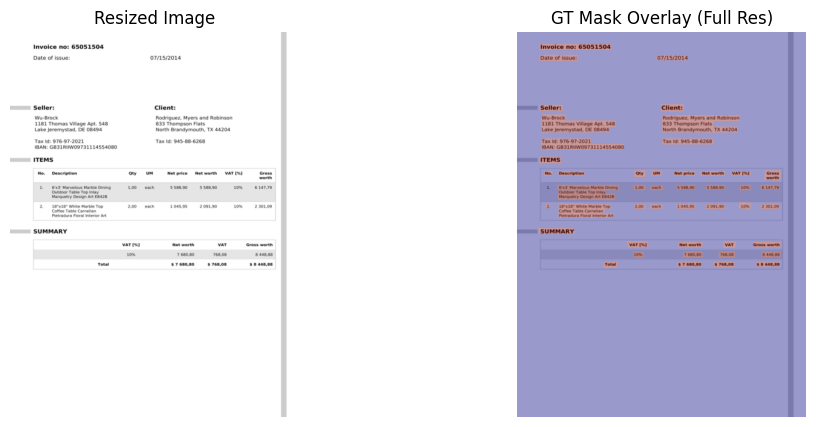

In [9]:
# Step 8: Sanity check – visualize one resized image + its GT mask

import matplotlib.pyplot as plt

ds_vis = val_ds#train_ds   # or val_ds if you want

ex_img, ex_mask = ds_vis[0]      # ex_mask: [1, H, W]
mask_np = ex_mask[0].cpu().numpy()
img_np = ex_img.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("GT Mask Overlay (Full Res)")
plt.imshow(img_np)
plt.imshow(mask_np, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()


In [10]:
# Step 9: Prepare model, optimizer, and AMP scaler

import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DBNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

# Get target size from dataset (should be 640 x 480)
H = train_loader.dataset.target_h
W = train_loader.dataset.target_w


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]
/tmp/ipython-input-437170678.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [28]:
# ============================================
# Step 10: Train with Validation + Save Best Model to Drive
# ============================================

import time
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# --------- Mount Google Drive BEFORE training ---------
from google.colab import drive
drive.mount('/content/drive')

# Create model directory inside Drive
!mkdir -p /content/drive/MyDrive/model

# Path where best model will be saved directly
best_model_path = "/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best.pth"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = DBNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

# Get full-res size for upsampling
H = train_loader.dataset.target_h
W = train_loader.dataset.target_w

best_val_loss = float("inf")


# ----------------------------
# TRAINING LOOP
# ----------------------------
for epoch in range(10):  # train for 10 epochs
    start_time = time.time()

    # -----------------
    # TRAIN
    # -----------------
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device, non_blocking=True)    # [B, 3, H, W]
        masks = masks.to(device, non_blocking=True)  # [B, 1, H, W]

        optimizer.zero_grad()

        with autocast():
            preds = model(imgs)  # [B, 1, H/32, W/32]

            # Upsample preds to full-resolution
            preds_up = F.interpolate(
                preds,
                size=(H, W),
                mode="bilinear",
                align_corners=False
            )

            loss = db_loss(preds_up, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # -----------------
    # VALIDATION
    # -----------------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            preds = model(imgs)
            preds_up = F.interpolate(
                preds,
                size=(H, W),
                mode="bilinear",
                align_corners=False
            )

            loss = db_loss(preds_up, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")

    # ---------------------------
    # SAVE BEST MODEL TO DRIVE
    # ---------------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New BEST model saved → {best_model_path}")
        print(f"     (val_loss={val_loss:.4f})")


print("Training finished. Best validation loss =", best_val_loss)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: cuda


/tmp/ipython-input-1457793095.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-1457793095.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 

In [11]:
# Step 11: Load the BEST saved model from Google Drive for inference

from google.colab import drive
drive.mount('/content/drive')

best_model_path = "/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best.pth"

best_model = DBNet().to(device)
state_dict = torch.load(best_model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()

print("✅ Best model loaded for inference from:")
print(best_model_path)


Mounted at /content/drive
✅ Best model loaded for inference from:
/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best.pth


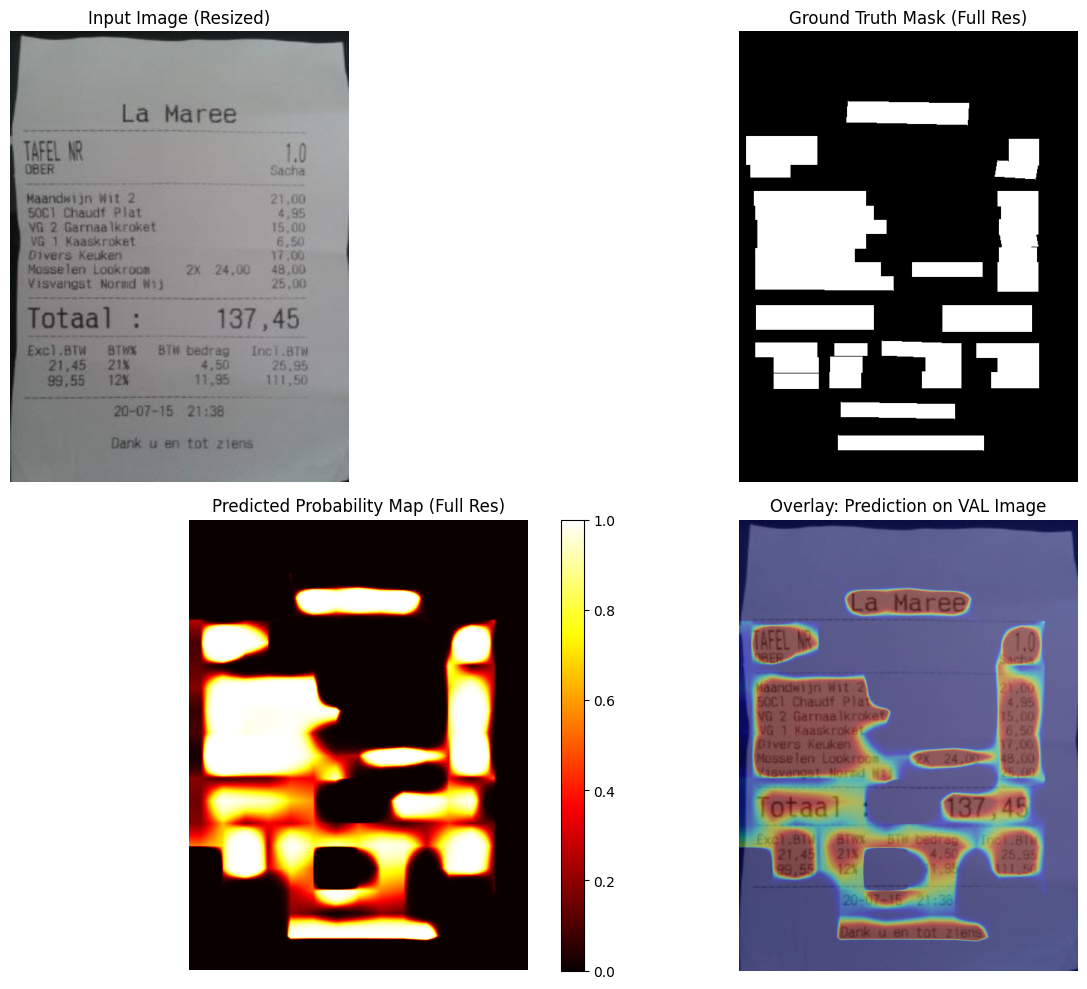

In [12]:
# Step 12: Visualize predictions vs GT on a VALIDATION sample (unseen during training)

import matplotlib.pyplot as plt
import torch.nn.functional as F

vis_dataset = val_loader.dataset  # <-- validation set

idx = 1  # you can change this index to inspect different val samples
img, gt_mask = vis_dataset[idx]   # img: [3, H, W], gt_mask: [1, H, W]

img_batch = img.unsqueeze(0).to(device)    # [1, 3, H, W]
gt_mask_b = gt_mask.unsqueeze(0).to(device)  # [1, 1, H, W]

H, W = img.shape[1], img.shape[2]

with torch.no_grad():
    pred_logits = best_model(img_batch)     # [1, 1, H/32, W/32]
    pred_logits_up = F.interpolate(
        pred_logits,
        size=(H, W),
        mode="bilinear",
        align_corners=False
    )
    pred_prob = torch.sigmoid(pred_logits_up)[0, 0].cpu().numpy()  # [H, W]

gt_np = gt_mask[0].cpu().numpy()           # [H, W]
img_np = img.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.title("Input Image (Resized)")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Ground Truth Mask (Full Res)")
plt.imshow(gt_np, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Predicted Probability Map (Full Res)")
plt.imshow(pred_prob, cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Overlay: Prediction on VAL Image")
plt.imshow(img_np)
plt.imshow(pred_prob, cmap="jet", alpha=0.4)
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
# Step 13: Evaluate model on the entire validation set using IoU

import torch
import torch.nn.functional as F

best_model.eval()

def compute_batch_iou(pred_probs, masks, thresh=0.5, eps=1e-6):
    """
    pred_probs: [B, 1, H, W] after sigmoid
    masks:      [B, 1, H, W] in {0,1}
    """
    # Binarize predictions
    preds_bin = (pred_probs >= thresh).float()

    # Flatten
    preds_flat = preds_bin.view(preds_bin.size(0), -1)
    masks_flat = masks.view(masks.size(0), -1)

    # Intersection and union
    intersection = (preds_flat * masks_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + masks_flat.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)  # avoid div by zero
    return iou  # [B]

iou_list = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device, non_blocking=True)      # [B, 3, H, W]
        masks = masks.to(device, non_blocking=True)    # [B, 1, H, W]

        # Forward pass
        logits = best_model(imgs)                      # [B, 1, H/32, W/32]
        logits_up = F.interpolate(
            logits,
            size=(H, W),
            mode="bilinear",
            align_corners=False
        )                                              # [B, 1, H, W]

        probs = torch.sigmoid(logits_up)               # [B, 1, H, W]

        # Compute IoU for this batch
        batch_iou = compute_batch_iou(probs, masks, thresh=0.5)
        iou_list.extend(batch_iou.cpu().tolist())

avg_iou = sum(iou_list) / len(iou_list)
print(f"📏 Average IoU on validation set: {avg_iou:.4f}")


📏 Average IoU on validation set: 0.6085


EasyOCR initialized. GPU: True


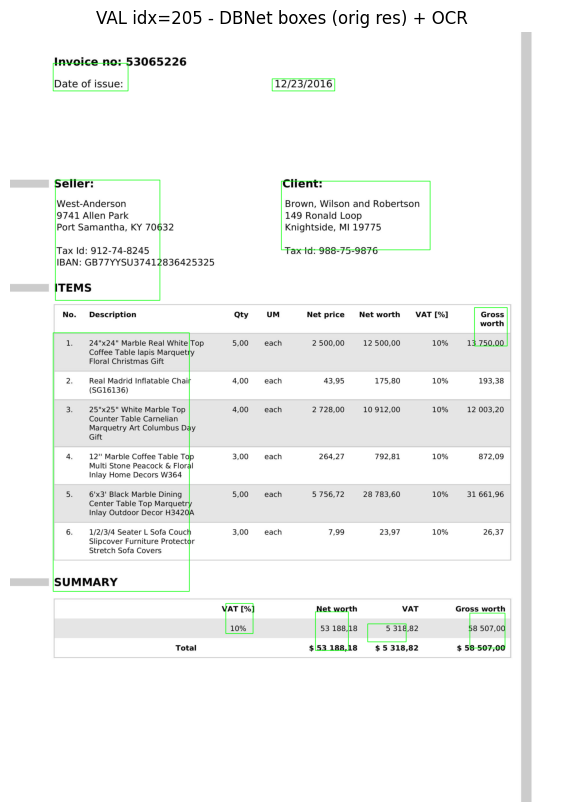

🔎 Validation sample idx=205
[0] bbox_orig=(1628, 2696, 175, 82)  text='5 318'
[1] bbox_orig=(2093, 2647, 160, 159)  text='58 507,00 0 Do7 Co'
[2] bbox_orig=(1390, 2641, 150, 176)  text='53 188, 53 188,'
[3] bbox_orig=(982, 2603, 124, 137)  text='AT [%_ 10%'
[4] bbox_orig=(196, 1370, 620, 1178)  text='1. 24"x24" Marble Real White Coffee Table lapis Marquetr Floral Christmas Gift 2 . Real Madrid Inflatable Chain (SG16136) 3 25"x25" White Marble Counter Table Carnelian Marquetry Art Columbus D= Gift 4 12" Marble Coffee Table To Multi Stone Peacock & Florz Inlay Home Decors W364 5 6\'x3\' Black Marble Dining Center Table Top Marquetr_ Inlay Outdoor Decor H3420 6 1/2/3/4 Seater L Sofa Couck Slipcover Furniture Protectc Stretch Sofa Covers SUMMARY Top'
[5] bbox_orig=(2114, 1255, 149, 175)  text='Gross worth ; 750.00'
[6] bbox_orig=(1235, 679, 677, 313)  text='Cllen: Brown, Wilson and Robertson 149 Ronald Loop Knightside, MI 19775'
[7] bbox_orig=(206, 674, 476, 548)  text='Seller: West-Anders

In [20]:
# === FINAL STEP: Full-resolution inference with DBNet + EasyOCR on VAL invoices ===
!pip install -q easyocr

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import easyocr

# Make sure we are on the right device and in eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)
best_model.eval()

# Initialize EasyOCR reader (English, GPU if available)
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
print("EasyOCR initialized. GPU:", torch.cuda.is_available())

def predict_text_from_val_idx_fullres(idx, prob_thresh=0.5, min_box_area=300, upscale_factor=2):
    """
    Use DBNet on resized image but run OCR on original full-resolution invoice.

    Assumes:
      - val_hf: HuggingFace validation split (with "image" and "polygons")
      - train_ds: DBNetDataset(train_hf) to read target_h/target_w
      - best_model: loaded DBNet with trained weights
      - device: torch.device
      - reader: EasyOCR reader
    """

    # 1) ORIGINAL validation example (full-res PIL)
    ex = val_hf[idx]
    pil_img = ex["image"]               # full-resolution PIL image
    orig_w, orig_h = pil_img.size

    # 2) Resize for model (same as DBNetDataset)
    model_h = train_ds.target_h         # e.g., 640
    model_w = train_ds.target_w         # e.g., 480

    pil_resized = pil_img.resize((model_w, model_h), Image.BILINEAR)
    img_tensor = transforms.ToTensor()(pil_resized).unsqueeze(0).to(device)  # [1,3,H,W]

    # 3) Run model
    with torch.no_grad():
        logits = best_model(img_tensor)         # [1,1,H/32,W/32]
        logits_up = F.interpolate(
            logits,
            size=(model_h, model_w),
            mode="bilinear",
            align_corners=False
        )                                       # [1,1,H,W]
        prob = torch.sigmoid(logits_up)[0, 0].cpu().numpy()  # [H,W]

    # 4) Threshold in model space
    mask_small = (prob >= prob_thresh).astype("uint8") * 255  # [H,W]

    # 5) Find contours (model space)
    contours, _ = cv2.findContours(mask_small, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 6) Original image in BGR for drawing / cropping
    img_orig_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    detected_texts = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < min_box_area:
            continue

        # Map (x,y,w,h) from model-space to original-space
        x0 = int(x        * orig_w / model_w)
        y0 = int(y        * orig_h / model_h)
        x1 = int((x + w)  * orig_w / model_w)
        y1 = int((y + h)  * orig_h / model_h)

        # Clamp to valid image bounds
        x0 = max(0, min(orig_w - 1, x0))
        y0 = max(0, min(orig_h - 1, y0))
        x1 = max(0, min(orig_w,     x1))
        y1 = max(0, min(orig_h,     y1))

        if x1 <= x0 or y1 <= y0:
            continue

        crop = img_orig_bgr[y0:y1, x0:x1]

        # Optional: upscale crop for easier OCR on small/blurred text
        if upscale_factor is not None and upscale_factor > 1:
            crop = cv2.resize(
                crop,
                (0, 0),
                fx=upscale_factor,
                fy=upscale_factor,
                interpolation=cv2.INTER_CUBIC
            )

        # 7) OCR on high-res crop
        ocr_result = reader.readtext(crop, detail=0)  # list of strings
        if not ocr_result:
            continue

        text = " ".join(ocr_result)
        detected_texts.append({
            "bbox_orig": (x0, y0, x1 - x0, y1 - y0),
            "text": text
        })

    # 8) Visualize green boxes on ORIGINAL invoice
    vis = img_orig_bgr.copy()
    for dt in detected_texts:
        x, y, w, h = dt["bbox_orig"]
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title(f"VAL idx={idx} - DBNet boxes (orig res) + OCR")
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.show()

    print(f"🔎 Validation sample idx={idx}")
    for i, dt in enumerate(detected_texts):
        print(f"[{i}] bbox_orig={dt['bbox_orig']}  text={dt['text']!r}")

    full_text = "\n".join([dt["text"] for dt in detected_texts])
    return detected_texts, full_text

# Example: run on one validation invoice
det_list, full_txt = predict_text_from_val_idx_fullres(idx=205, prob_thresh=0.5)
print("\n========== FULL PREDICTED TEXT (VAL idx=205, FULL-RES OCR) ==========")
print(full_txt)
